In [1]:
import pandas as pd
import requests

In [2]:
def get_news():
    url = ('http://newsapi.org/v2/top-headlines?'
           'country=us&'
           'apiKey=b4f4c90718f24700bd60d599cee534ec')
    response = requests.get(url)
    return response.json()

In [3]:
def get_dataframe(data, column_names):
    news = []
    for article in data['articles']:
        news.append([
            article['source']['id'],
            article['source']['name'],
            article['author'],
            article['title'],
            article['description'],
            article['url'],
            article['urlToImage'],
            article['publishedAt'],
            article['content']
        ])
    return pd.DataFrame(news, columns = column_names)

In [4]:
data_from_api = get_news()

In [5]:
column_names = ['id', 'name', 'author', 'title', 'description', 
           'url', 'urlToImage', 'publishedAt', 'content']
df_from_api = get_dataframe(data_from_api, column_names)

In [6]:
df_from_api.head(3)

,id,name,author,title,description,url,urlToImage,publishedAt,content
0,fox-news,Fox News,Stephanie Pagones,"FBI, Florida authorities pursuing leads as wat...","The FBI, Secret Service and Florida law enforc...",https://www.foxnews.com/us/fbi-florida-authori...,https://static.foxnews.com/foxnews.com/content...,2021-02-09T15:54:17Z,"The FBI, Secret Service and Floridalaw enforce..."
1,fox-news,Fox News,Tyler McCarthy,Britney Spears fans call out Diane Sawyer over...,Diane Sawyer is facing backlash for a 2003 int...,https://www.foxnews.com/entertainment/britney-...,https://static.foxnews.com/foxnews.com/content...,2021-02-09T15:31:43Z,Diane Sawyer is facing backlash for a 2003 int...
2,ars-technica,Ars Technica,Kyle Orland,Cyberpunk 2077 developer hit with ransomware a...,Studio vows not to negotiate with hackers.,https://arstechnica.com/gaming/2021/02/cyberpu...,https://cdn.arstechnica.net/wp-content/uploads...,2021-02-09T15:22:00Z,Enlarge/ How would Johnny Silverhand deal with...


In [7]:
df_from_api.shape

(20, 9)

In [8]:
df_from_api.to_csv('news_from_api.csv')

In [9]:
import nltk
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [10]:
df_train = pd.read_csv('news_articles_exported.csv')
df_train.head()

,text,label
0,print they should pay all the back all the mon...,Real
1,why did attorney general loretta lynch plead t...,Real
2,red state \nfox news sunday reported this mor...,Real
3,email kayla mueller was a prisoner and torture...,Real
4,email healthcare reform to make america great ...,Real


In [11]:
df_train.shape

(2017, 2)

In [12]:
df_train['label'] = df_train['label'].replace({'Real' : 'Likely true', 'Fake' : 'Likely false'})

In [13]:
df_train.isnull().sum()

text     45
label     0
dtype: int64

In [14]:
df_train = df_train.dropna(axis = 0)

In [15]:
df_train['label'].value_counts()

Likely false    1218
Likely true      754
Name: label, dtype: int64

In [16]:
df_test = pd.read_csv('news_from_api_exported.csv')
df_test.head()

,Content
0,"LiveUpdated Feb. 9, 2021, 9:56 a.m. ET\r\nFeb...."
1,Dramatic video from the Wisconsin Department o...
2,MicroStrategy's stock is up more than 700% sin...
3,Antonio Brown did just enough to impact Super ...
4,The health and safety protocols agreed upon by...


In [17]:
df_test.shape

(18, 1)

In [18]:
df_test.isnull().sum()

Content    0
dtype: int64

In [19]:
stopwords = set(nltk.corpus.stopwords.words('english'))
punctuations = set(string.punctuation)

In [20]:
def clean_text(df, column):
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() \
                                                      if word not in stopwords \
                                                      and word not in punctuations]))

In [21]:
clean_text(df_train, 'text')
clean_text(df_test, 'Content')

In [22]:
df_train['text'] = df_train['text'].str.lower()
df_test['Content'] = df_test['Content'].str.lower()

In [23]:
df_train.head()

,text,label
0,print pay back money plus interest entire fami...,Likely true
1,attorney general loretta lynch plead fifth bar...,Likely true
2,red state fox news sunday reported morning ant...,Likely true
3,email kayla mueller prisoner tortured isis cha...,Likely true
4,email healthcare reform make america great sin...,Likely true


In [24]:
df_test.head()

,Content
0,"liveupdated feb. 9, 2021, 9:56 a.m. et feb. 9,..."
1,dramatic video wisconsin department transporta...
2,"microstrategy's stock 700% since august, virgi..."
3,antonio brown enough impact super bowl lv tamp...
4,the health safety protocols agreed upon major ...


In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df_train['text'], df_train['label'], 
    test_size = 0.3, random_state = 42) 

In [26]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)

/home/mariam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
y_pred_train = model.predict(X_train)
print("Accuracy train: {}%".format(accuracy_score(y_train, y_pred_train)))
y_pred_valid = model.predict(X_valid)
print("Accuracy valid: {}%".format(accuracy_score(y_valid, y_pred_valid)))

Accuracy train: 0.9963768115942029%
Accuracy valid: 0.722972972972973%


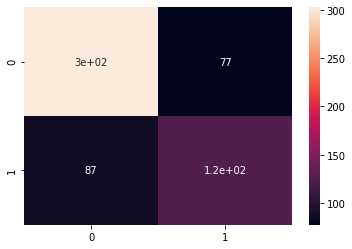

In [28]:
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot = True)

In [29]:
y_pred_test = model.predict(df_test['Content'])

In [30]:
df_test['label'] = y_pred_test
df_test.head()

,Content,label
0,"liveupdated feb. 9, 2021, 9:56 a.m. et feb. 9,...",Likely false
1,dramatic video wisconsin department transporta...,Likely false
2,"microstrategy's stock 700% since august, virgi...",Likely false
3,antonio brown enough impact super bowl lv tamp...,Likely false
4,the health safety protocols agreed upon major ...,Likely false
